# Test technique entretien Audensiel

Notebook réalisé par Marie Bétend dans le cadre d'un entretien.

Les données sont sous la forme : 
* Class: no-recurrence-events, recurrence-events
* age: 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, 70-79, 80-89, 90-99.
* menopause: lt40, ge40, premeno.
* tumor-size: 0-4, 5-9, 10-14, 15-19, 20-24, 25-29, 30-34, 35-39, 40-44,45-49, 50-54, 55-59.
* inv-nodes: 0-2, 3-5, 6-8, 9-11, 12-14, 15-17, 18-20, 21-23, 24-26,27-29, 30-32, 33-35, 36-39.
* node-caps: yes, no.
* deg-malig: 1, 2, 3.
* breast: left, right.
* breast-quad: left-up, left-low, right-up,	right-low, central.
* irradiat:	yes, no.

## Premier apreçu des données

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns


In [2]:
colnames = ['Class','age','menopause','tumor-size','inv-nodes','node-caps','deg-malig','breast','breast-quad','irradiat']
data = pd.read_csv('breast-cancer.data', delimiter = ',', names = colnames, na_values = '?')

In [3]:
data.head()

,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


In [4]:
def perc_no_hue(plot, feature):
    total = len(data[feature])
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() /2 - 0.1*p.get_width()
        y = p.get_y() + p.get_height()/2
        plot.annotate(percentage, (x, y), color='black')

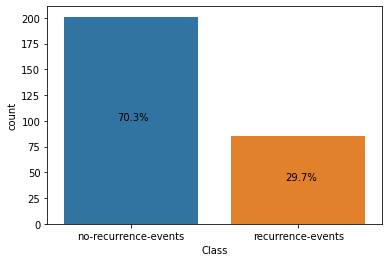

In [5]:
plot = sns.countplot(x="Class", data=data)
perc_no_hue(plot, "Class")

Nous constatons qu'une des classes est sous-représentée. Il faudra donc le prendre en compte pour l'arbre de décision.

In [6]:
data[data.isna().any(axis=1)]

,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
145,no-recurrence-events,40-49,premeno,25-29,0-2,NaN,2,left,right_low,yes
163,no-recurrence-events,60-69,ge40,25-29,3-5,NaN,1,right,left_up,yes
164,no-recurrence-events,60-69,ge40,25-29,3-5,NaN,1,right,left_low,yes
183,no-recurrence-events,50-59,ge40,30-34,9-11,NaN,3,left,left_up,yes
184,no-recurrence-events,50-59,ge40,30-34,9-11,NaN,3,left,left_low,yes
206,recurrence-events,50-59,ge40,30-34,0-2,no,3,left,NaN,no
233,recurrence-events,70-79,ge40,15-19,9-11,NaN,1,left,left_low,yes
263,recurrence-events,50-59,lt40,20-24,0-2,NaN,1,left,left_up,no
264,recurrence-events,50-59,lt40,20-24,0-2,NaN,1,left,left_low,no


Comme nous n'avons pas beaucoup de données, nous allons remplacer les valeurs inconnues par les catégories majoritaires de chaque colonne, donc ici _node-caps_ et _breast-quad_.

In [7]:
data['node-caps'].value_counts()

no     222
yes     56
Name: node-caps, dtype: int64

In [8]:
data['breast-quad'].value_counts()

left_low     110
left_up       97
right_up      33
right_low     24
central       21
Name: breast-quad, dtype: int64

In [9]:
data['node-caps'].fillna('no', inplace = True)
data['breast-quad'].fillna('left_low', inplace = True)


Comme les données sont "céatégoriques", on doit les encoder pour pouvoir utiliser un arbre de décision, nous allons encoder chaque colonne avec ce qui semble appropriée pour chacune.

## Encodage

Pour les colonnes _age_, _tumor-size_, _inv-nodes_ nous allong prendre le milieu des intervalles décrits.


In [10]:
def to_middle(df, labels):
    for e in labels:
        for j in df[e].unique() :
            tmp = j.split('-')
            new_val = (int(tmp[0]) + int(tmp[1])) / 2
            df[e].replace(to_replace = j,value = new_val, inplace = True )
            
lab_middle = ['age', 'tumor-size', 'inv-nodes']
to_middle(data, lab_middle )

In [13]:
data.head()

,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,34.5,premeno,32.0,1.0,no,3,left,left_low,no
1,no-recurrence-events,44.5,premeno,22.0,1.0,no,2,right,right_up,no
2,no-recurrence-events,44.5,premeno,22.0,1.0,no,2,left,left_low,no
3,no-recurrence-events,64.5,ge40,17.0,1.0,no,2,right,left_up,no
4,no-recurrence-events,44.5,premeno,2.0,1.0,no,2,right,right_low,no


Il nous reste donc les colonnes _menopause_, _node-caps_, _deg-malig_, _breast_, _breast-quad_ et _irradiat_. 

Nous nous contenterons de passer _deg-malig_ en en type int.
Les colonnes _node-caps_, _breast_, et _irradiat_ ne contenant que 2 valeurs, nous pouvons les encoder avec 0 et 1. 

Nous encoderons enfin _menopause_ et _breast-quad_ avec des vecteurs one-hot, bien que nous aurions pu choisir un encodage numerique pour _menopause_ car il y a une notion de progression qui n'existe pas pour la deuxieme colonne. 


In [14]:
data['deg-malig'].astype(int)

0      3
1      2
2      2
3      2
4      2
      ..
281    2
282    3
283    1
284    3
285    3
Name: deg-malig, Length: 286, dtype: int64

In [15]:
def to_01 (df, cols):
    for c in cols :
        df[c].replace(to_replace = 'no',value = 0, inplace = True)
        df[c].replace(to_replace = 'yes',value = 1, inplace = True)

col_01 = ['node-caps', 'irradiat']
to_01(data, col_01)
data['breast'].replace(to_replace = 'left',value = 0, inplace = True )
data['breast'].replace(to_replace = 'right',value = 1, inplace = True )

In [18]:
def to_oneHot (col) :
    global data
    for c in col :
        data = pd.get_dummies(data,columns = [c])

col_oneHot = ['menopause','breast-quad']
to_oneHot(col_oneHot)


In [19]:
data.head()

,Class,age,tumor-size,inv-nodes,node-caps,deg-malig,breast,irradiat,menopause_ge40,menopause_lt40,menopause_premeno,breast-quad_central,breast-quad_left_low,breast-quad_left_up,breast-quad_right_low,breast-quad_right_up
0,no-recurrence-events,34.5,32.0,1.0,0,3,0,0,0,0,1,0,1,0,0,0
1,no-recurrence-events,44.5,22.0,1.0,0,2,1,0,0,0,1,0,0,0,0,1
2,no-recurrence-events,44.5,22.0,1.0,0,2,0,0,0,0,1,0,1,0,0,0
3,no-recurrence-events,64.5,17.0,1.0,0,2,1,0,1,0,0,0,0,1,0,0
4,no-recurrence-events,44.5,2.0,1.0,0,2,1,0,0,0,1,0,0,0,1,0


## Arbre de décision 

In [20]:
X = data.drop(['Class'], axis = 1)
Y = data['Class']

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20,random_state = 42, stratify = Y)

In [22]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

DecisionTreeClassifier()

In [23]:
y_pred = classifier.predict(X_test)

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[26 15]
 [12  5]]
                      precision    recall  f1-score   support

no-recurrence-events       0.68      0.63      0.66        41
   recurrence-events       0.25      0.29      0.27        17

            accuracy                           0.53        58
           macro avg       0.47      0.46      0.46        58
        weighted avg       0.56      0.53      0.54        58



In [25]:
print('Model test Score: %.3f, ' %classifier.score(X_test, y_test), 
      'Model training Score: %.3f' %classifier.score(X_train, y_train))

Model test Score: 0.534,  Model training Score: 0.978


Essayons maintenant d'ameliorer les parametres pour avoir de meilleures performance, notamment sur la deuxieme classe qui est tres mal identifiee.

In [44]:
from sklearn.model_selection import GridSearchCV

tuned_parameters = [{'criterion' : ['gini', 'entropy'],
                    'max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
                     'min_samples_split': [2,4,6,8,10],
                    'min_samples_leaf': [1,2,3,4,5],
                    'class_weight' : [None, 'balanced'],
                    'max_features' : ['auto', 'sqrt', 'log2']}]
scores = ['recall']
for score in scores:
    
    print()
    print(f"Tuning hyperparameters for {score}")
    print()
    
    clf = GridSearchCV(
        DecisionTreeClassifier(), tuned_parameters,
        scoring = f'{score}_macro'
    )
    clf.fit(X_train, y_train)
    
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)


Tuning hyperparameters for recall

Best parameters set found on development set:

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8}


In [45]:
classifier_Tuned = DecisionTreeClassifier(class_weight= 'balanced', criterion= 'gini',
                                          max_depth= 10, max_features='auto', min_samples_leaf= 5,
                                          min_samples_split= 10)
classifier_Tuned.fit(X_train, y_train)
y_predTuned = classifier_Tuned.predict(X_test)
print(confusion_matrix(y_test, y_predTuned))
print(classification_report(y_test, y_predTuned))

[[21 20]
 [ 3 14]]
                      precision    recall  f1-score   support

no-recurrence-events       0.88      0.51      0.65        41
   recurrence-events       0.41      0.82      0.55        17

            accuracy                           0.60        58
           macro avg       0.64      0.67      0.60        58
        weighted avg       0.74      0.60      0.62        58



## Piste d'amélioration

### Bagging

In [46]:
from sklearn.ensemble import BaggingClassifier

bgclassifier = BaggingClassifier(base_estimator=classifier_Tuned)
bgclassifier.fit(X_train, y_train)

y_predTuned = bgclassifier.predict(X_test)
print(confusion_matrix(y_test, y_predTuned))
print(classification_report(y_test, y_predTuned))

[[29 12]
 [ 8  9]]
                      precision    recall  f1-score   support

no-recurrence-events       0.78      0.71      0.74        41
   recurrence-events       0.43      0.53      0.47        17

            accuracy                           0.66        58
           macro avg       0.61      0.62      0.61        58
        weighted avg       0.68      0.66      0.66        58



### Boosting

In [47]:
from sklearn.ensemble import AdaBoostClassifier

aBclassifier = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200 )
aBclassifier.fit(X_train, y_train)

y_predTuned = aBclassifier.predict(X_test)
print(confusion_matrix(y_test, y_predTuned))
print(classification_report(y_test, y_predTuned))

[[33  8]
 [11  6]]
                      precision    recall  f1-score   support

no-recurrence-events       0.75      0.80      0.78        41
   recurrence-events       0.43      0.35      0.39        17

            accuracy                           0.67        58
           macro avg       0.59      0.58      0.58        58
        weighted avg       0.66      0.67      0.66        58

